# Realizing topologically ordered states on a quantum processor

## Introduction


Quantum computing, an idea proposed by Richard Feynman in his famous Caltech lecture, is a powerful possible future tool for solving various optimization and physical problems previously inaccessible to classical computers. The cornerstone of building of a reliable quantum computer is implementation of fault-tolerant computation procedure, which is not susceptible to external noise and allows performing long computations. Such fault-tolerant computing can be implemented, as shown by Kitaev, within braiding the so-called anyons, new exotic particles with non-trivial mutual statistics. The latter is the defining feature of anyons and means that the system wave function in 2 dimensions picks up a non-zero phase (or even changes to a different state) when moving one anyon around the other. This non-trivial phase is topologically protected and guarantees high degree of resistivity to noise. Later on, Kitaev proposed the lattice spin model, Toric code, in paper "[Fault-tolerant quantum computation by anyons](https://arxiv.org/abs/quant-ph/9707021)", in which those anyons are realized. Ironically, those anyons within this Toric code model were simulated by Google on a noisy superconducting computer. In this project, we aimed at reproduction of the results of this work.

A good source for study is [Leggett's intro](https://courses.physics.illinois.edu/phys598PTD/fa2013/L26.pdf)
to toric code.

## Ground state preparation
The toric code Hamiltonian
$$ H = -\sum_{s} A_{s} - \sum_{p} B_{p}$$
is defined in terms of qubits living on the edges of a square lattice.
The "star" operators $A_s = \prod_{i\in s} Z_i$ are products of Pauli $Z$ operators touching each star ($+$, blue). The "plaquette" operators $B_p = \prod_{j \in p} X_j$ are products of Pauli $X$ operators on each plaquette ($\square$, purple).

Since all the operators in the toric code Hamiltonian commute, it is relatively simple to find ground state explicitly. For that we start from a state from which all stars are in ground state, i.e., $\langle A_s \rangle = 1$, which is in our case just $| 0 \rangle^{\otimes N}$ and then project it on the subspace for which $\langle B_p \rangle = 1$ by applying $(\mathbb{I}+B_p)$ operator. This operator is then decomposed in a Hadamard operator on representative qubit, followed by a sequence of carefully ordered CNOT operators. This allows to prepare ground state in time linear in the width of the system.

In [1]:
from toric_code import get_toric_code

x, y = 5, 7  # System size (should be odd)
tc = get_toric_code(x, y)
print(f'Number of qubits: {tc.circ.num_qubits}, depth: {tc.circ.depth()}')
print(f'Plaquette count: {tc.plaquette_x}*{tc.plaquette_y}')

Number of qubits: 31, depth: 7
Plaquette count: 4*3


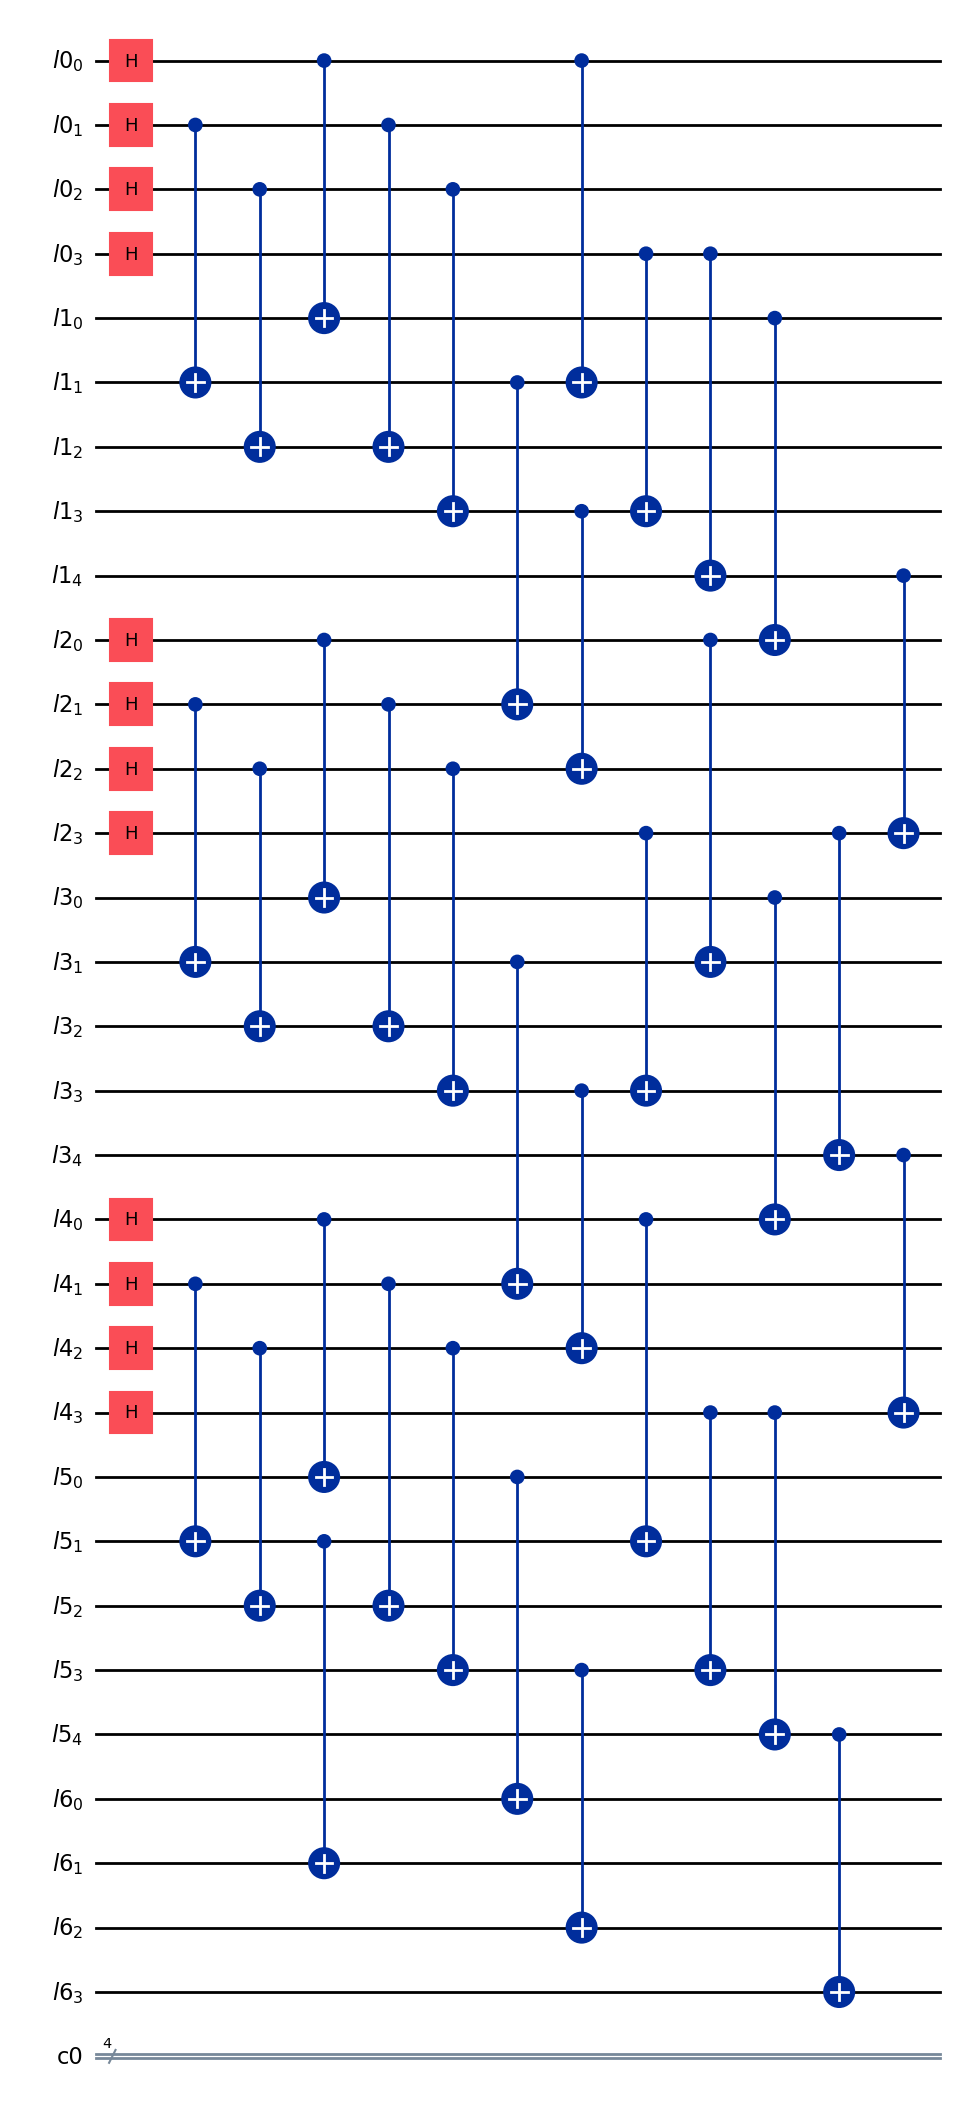

In [2]:
tc.circ.draw('mpl')

### Verify ground state preparation
Ground state fulfills $A_s=B_p=1$, i.e., which we can check by applying corresponding operator to plaquettes and stars.


In [3]:
from toric_code_tests.test_init import get_plaquette_ev

import numpy as np
from qiskit_aer import AerSimulator
from qiskit import transpile

from toric_code import get_toric_code
from toric_code_matching import get_star_matching

In [4]:
# Use Aer's simulator
backend = AerSimulator(method='extended_stabilizer')

In [5]:
px, py = tc.plaquette_x, tc.plaquette_y

for i in range(px):
    for j in range(py):
        ev = get_plaquette_ev(backend, (x, y), (i, j))
        print(f'Plaquette ({i},{j}): {ev}')

Plaquette (0,0): 1.0
Plaquette (0,1): 1.0
Plaquette (0,2): 1.0
Plaquette (1,0): 1.0
Plaquette (1,1): 1.0
Plaquette (1,2): 1.0
Plaquette (2,0): 1.0
Plaquette (2,1): 1.0
Plaquette (2,2): 1.0
Plaquette (3,0): 1.0
Plaquette (3,1): 1.0
Plaquette (3,2): 1.0


In [6]:
from toric_code_tests.test_init import get_star_ev

sx, sy = tc.star_x, tc.star_y

for i in range(sx):
    for j in range(sy):
        if len(get_star_matching(i, j, tc.y, tc.x)) < 4:
            continue

        ev = get_star_ev(backend, (x, y), (i, j))
        print(f'Star ({i},{j}): {ev}')

Star (1,2): 1.0
Star (1,3): 1.0
Star (2,2): 1.0
Star (2,3): 1.0


### Entropy
Topological entropy is a property of many-body system. While entangelement entropy of the ground often follows area law, the constant correction to this value is called topological entropy. Since this value is independent on the size of the subsystem, it captures the universal properties and its non-zero value is an evidence to the presence of long range quantum entanglement.

The topological entropy can be calculated using [Kitaev-Preskill](https://arxiv.org/abs/hep-th/0510092) formula:
$$S_{\text{topo}} \equiv S_A + S_B + S_C − S_{AB} − S_{BC} − S_{AC} + S_{ABC}$$

In case of toric code, the total entropy is proportional to the number of the stars touched by the boundary of the subsystem (red line in a figure below).

Here we'll demonstrate calculations of both second Rényi entropy and for a single $2\times 3$ subsystem. For that we use randomized measurement (RM) protocol. The details can be found in the supplementary material of the paper.

In [7]:
from topo_entropy import get_all_2x3_left_non_corner

expected_values = [(2., 2., 2.), (4., 3., 4.), (4.,)]

qubits = get_all_2x3_left_non_corner((x, y))[0]

In [8]:
from topo_entropy import calculate_s_subsystems, ABC_DIVISION_2x3_LEFT
from tqdm import tqdm
import itertools

Pauli basis: measure in every possible combination of Pauli basis ($3^6$ options).

In [9]:
all_counts = []

all_gates = [''.join(x) for x in itertools.product('xyz', repeat=len(qubits))]
for gates in tqdm(all_gates):
    tc = get_toric_code(x, y, len(qubits))

    tc.measure_pauli(qubits, gates)

    job = backend.run(transpile(tc.circ, backend), shots=15000)  # note: number of shots is important
    result = job.result()
    counts = result.get_counts(tc.circ)
    all_counts.append(counts)
calculated_values = calculate_s_subsystems(all_counts, ABC_DIVISION_2x3_LEFT)
for expect, calc in zip(expected_values, calculated_values):
    for ve, vc in zip(expect, calc):
        print(f'Theoretical value of S/ln(2): {ve}. Measured value: {vc / np.log(2)} ')

Stopo = sum(calculated_values[0]) - sum(calculated_values[1]) + sum(calculated_values[2])
print(f'Theoretical value of Stopo/ln(2): -1. Measured value: {Stopo / np.log(2)} ')

100%|██████████| 729/729 [00:02<00:00, 346.72it/s]

Theoretical value of S/ln(2): 2.0. Measured value: 1.998884393604201 
Theoretical value of S/ln(2): 2.0. Measured value: 1.9988415192855216 
Theoretical value of S/ln(2): 2.0. Measured value: 1.9988827060466592 
Theoretical value of S/ln(2): 4.0. Measured value: 3.977825288126209 
Theoretical value of S/ln(2): 3.0. Measured value: 2.9887207031830596 
Theoretical value of S/ln(2): 4.0. Measured value: 3.9781480637086877 
Theoretical value of S/ln(2): 4.0. Measured value: 3.9082208851357905 
Theoretical value of Stopo/ln(2): -1. Measured value: -1.0398645509457851 


Randomized measurement: measure after random unitary drawn from Haar distribution.

### Braiding
There are three types of quasiparticle $e$, $m$ and $\psi$. We demonstrate braiding of $e$ with $m$,
 as well as fermionic exchange statistics of $\psi$.
 
For instance, to measure the mutual statistics between the $e$ and $m$ anyons, we start with the preparation of the toric code ground state, then create the anyons and braid them using the controlled $XXXX$ operator. The resulting phase is measured within the Hadamard test protocol with an ancila qubit.

In [10]:
from topo_braiding import apply_cxxxx_on_square, create_e_particles, create_m_particles, apply_cxxyyzz_on_rectangle

In [11]:
for sq in [(0, 2), (0, 3), (2, 2), (2, 1)]:
    tc = get_toric_code(x, y, classical_bit_count=1, ancillas_count=1)

    x_string = [(2, 1), (2, 2)]
    create_e_particles(tc, x_string)

    z_string = [(1, 4), (0, 3), (1, 3)]  # , (0,2), (1,2)]
    create_m_particles(tc, z_string)

    tc.circ.h(tc.ancillas[0])
    apply_cxxxx_on_square(tc, sq)
    tc.circ.h(tc.ancillas[0])

    tc.circ.measure(tc.ancillas[0], 0)
    Nshots = 10000
    job = backend.run(transpile(tc.circ, backend), shots=Nshots)
    result = job.result()
    counts = result.get_counts(tc.circ)

    if '0' not in counts:
        counts['0'] = 0
    if '1' not in counts:
        counts['1'] = 0

    cos_theta = (counts['0'] - counts['1']) / Nshots
    expected_res = -1. if sq in [(0, 2), (0, 3)] else 1.
    print(f'Expected value of cos(theta): {expected_res}. Measured value: {cos_theta}')

Expected value of cos(theta): -1.0. Measured value: -1.0
Expected value of cos(theta): -1.0. Measured value: -1.0
Expected value of cos(theta): 1.0. Measured value: 1.0
Expected value of cos(theta): 1.0. Measured value: 1.0


In [13]:
sq = (0, 3)
tc = get_toric_code(x, y, classical_bit_count=1, ancillas_count=1)

x_strings = [[(2, 1), (2, 2)],
             [(1, 4), (3, 4)]]
for x_string in x_strings:
    create_e_particles(tc, x_string)

z_strings = [[(2, 3), (3, 3), (4, 3)],
             [(3, 1), (4, 1), (3, 2)], ]
for z_string in z_strings:
    create_m_particles(tc, z_string)

tc.circ.h(tc.ancillas[0])
apply_cxxyyzz_on_rectangle(tc, sq)
tc.circ.h(tc.ancillas[0])

tc.circ.measure(tc.ancillas[0], 0)
Nshots = 10000
job = backend.run(transpile(tc.circ, backend), shots=Nshots)
result = job.result()
counts = result.get_counts(tc.circ)

if '0' not in counts:
    counts['0'] = 0
if '1' not in counts:
    counts['1'] = 0
print(counts)

cos_theta = (counts['0'] - counts['1']) / Nshots
expected_res = -1.
print(f'Expected value of cos(theta): {expected_res}. Measured value: {cos_theta}')

Simulation failed and returned the following error message:
ERROR:  [Experiment 0] a circuit requires more memory than max_memory_mb.


QiskitError: 'Data for experiment "circuit-11254" could not be found.'